### Kullback Leibler method

This notebook shows the use of the Kullback-Leibler divergence method to check similarity between the measures and different simulations, these simulations were made considering different values of numerical aberture (NA). 

Considering two probability distributions $P$ and $Q_{NA}$, where $P$ represents the measures, $Q_{NA}$ is the probability distribution for a specific NA, constructed with a theoretical data acquiredy. 

A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Load data from simulations](#2)

- [3 - Kullback Leibler method](#3)

<a name='1'></a> 
### 1. Packages and imports

In [117]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import rel_entr
from scipy import stats
from scipy.stats import norm
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
plt.rcParams.update({'font.size': 15})

<a name='2'></a> 
### 2. Load data from simulations and experiment and preprocessing

The data loaded here is disposed in a folder entitled as `data`, which can be found in the root folder of the project, inside the `data` folder there will be a `simulations` folder, and lastly this, will be a subfolder named as `kl`.

There will be several `.txt` files, named as, for example  `OBB_positions_NA_34_exp_3.txt`. Each file contains the $x$, $y$ and $z$ coordinates of the particle as a function of time. The name of these files represents the value of NA used and the number of the experiment.


In [118]:
simulations = {}
folder = '../data/simulations/kl'
for file in tqdm(os.listdir(folder)):
    if file.split('.')[1] == 'txt':
        na = file.split('_')[3]
        exp_id = file.split('_')[5].split('.')[0]
        if simulations.get(na) is not None:
            pass
        else:
            simulations[na] = {}
        array = np.loadtxt(f'{folder}/{file}', delimiter=',')
        x, y, z = array[0,:], array[1,:], array[2,:]
        simulations[na][exp_id] = {'x': x, 'y': y, 'z': z}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:40<00:00,  5.11it/s]


Measured datasets obtained from the extraction of data from video is found in the `dataframes` folder, inside `data`. There will be folder for `raw`, `outliers` and `filtered` dataframes. For this analysis the data used was extracted from the longest video, named as `hour.csv`.

In [119]:
measures = pd.read_csv('../data/dataframes/filtered/hour.csv')
measures.head()

,filename,radius,z,index,x-um,y-um
0,frame46006.jpg,19.235483,104.048216,46006,8.468811e-09,1.756195e-08
1,frame20383.jpg,18.836752,107.930095,20383,-6.497804e-09,1.765377e-08
2,frame49335.jpg,18.309128,107.099475,49335,-3.161867e-09,-2.705666e-08
3,frame10240.jpg,17.793230,106.272967,10240,-5.420442e-09,-1.591671e-08
4,frame56215.jpg,18.137596,105.154529,56215,7.311082e-09,2.798151e-08


After loading both simulations and experiment datasets, the simulations dataset are going to be reorganized in a way to fill a 3D tensor for each NA simulated. This tensor is going to be $99999\times 5 \times 3$, where $5$ is the number of experiment done for that NA.

In [120]:
N = 99999
averaged = {}
for key in simulations.keys():
    if int(key)>=28:
        sub_dict = simulations[key]
        num_exp = len(sub_dict.keys())
        pos_array = np.zeros((int(N), int(num_exp), 3))
        for sub_key in sub_dict.keys():         
            pos_array[:, int(sub_key)-1, 0] = sub_dict[sub_key]['x']
            pos_array[:, int(sub_key)-1, 1] = sub_dict[sub_key]['y']
            pos_array[:, int(sub_key)-1, 2] = sub_dict[sub_key]['z']
        averaged[key] = {'x': pos_array[:,:,0],
                         'y': pos_array[:,:,1],
                         'z': pos_array[:,:,2]}

<a name='3'></a> 
### 3. Kullback Leibler method

The KL method analysis two probability distributions, comparing the divergence between then. To apply this methodology the probability distributions that are encountered from the data must be computed first. An auxiliary function `create_pdf` creates the probability distribution function from a specific array and for a given interval of variables. In the following cells an example of the usage of this function is showed.

In [121]:
def create_pdf(measure, group_r):
    df = pd.DataFrame()
    df['measure'] = measure
    groups = df.groupby([pd.cut(df.measure, group_r)], as_index=False)
    grouped_df = groups.size().unstack()
    return grouped_df['size'].values/grouped_df['size'].values.sum()

In [122]:
pdf = create_pdf(measures['x-um'], np.linspace(measures['x-um'].values.min(), measures['x-um'].values.max(), 25))

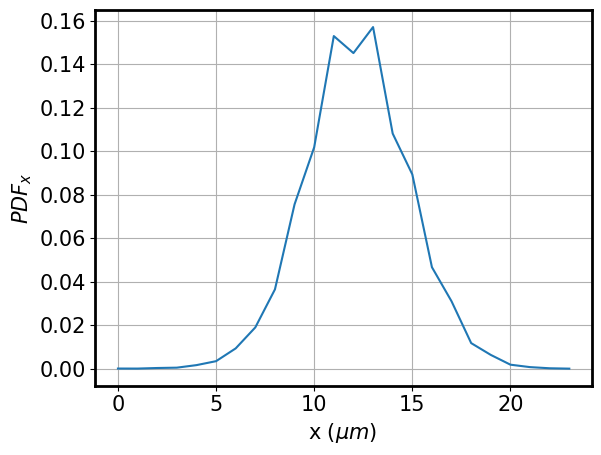

In [123]:
plt.plot(pdf)
plt.ylabel(r'$PDF_x$')
plt.xlabel(r'x ($\mu m$) ')
plt.grid()
plt.show()

Finally, we may define the functino that will be responsible for the magic that is computing the KL divergence

$$
D_{KL}(P|Q) = \sum_{x\in X}P(x)\log\Big(\frac{P(x)}{Q(x)}\Big)
$$

An value of epsilon is added to avoid divisions by zero.

In [124]:
def kl_divergence(a, b, epsilon=10**-12):
    a = np.asarray(a, dtype=np.float) + epsilon
    b = np.asarray(b, dtype=np.float) + epsilon
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

Now the KL divergence can be computed for each NA and each experiment made, allowing to fill the columns of a dataframe. The KL of each experiment and NA is computed by taking the average between the KL for $x$ and for $y$.

In [125]:
intervals = {'x': np.linspace(measures['x-um'].values.min(), measures['x-um'].values.max(), 100),
             'y': np.linspace(measures['y-um'].values.min(), measures['y-um'].values.max(), 100)}
nas, kls, axiss, exp = [], [], [], []
for key in tqdm(averaged.keys()):
    for axis in ['x', 'y']:
        for i in range(averaged[key][axis].shape[1]):
            nas.append(0.01*int(key))
            sim = averaged[key][axis][:,i] - averaged[key][axis][:,i].mean()
            kls.append(kl_divergence(create_pdf(measures[f'{axis}-um'].values, intervals[axis]), 
                                     create_pdf(sim, intervals[axis])))
            axiss.append(axis)
            exp.append(i)

  0%|                                                                                                                 | 0/33 [00:00<?, ?it/s]/tmp/ipykernel_22708/789988432.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, dtype=np.float) + epsilon
/tmp/ipykernel_22708/789988432.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

In [126]:
df = pd.DataFrame()
df['na'] = nas
df['kl'] = kls
df['axis'] = axiss
df['exp'] = exp
df = df.groupby(by=['na', 'exp'], as_index=False).mean()
df.head()

,na,exp,kl
0,0.28,0,0.420763
1,0.28,1,0.877014
2,0.28,2,0.547062
3,0.28,3,0.476781
4,0.28,4,0.714051


In [127]:
mean = df.groupby(by=['na'], as_index=False).mean()['kl'].values
std = df.groupby(by=['na'], as_index=False).std()['kl'].values
na = df.groupby(by=['na'], as_index=False).mean()['na'].values

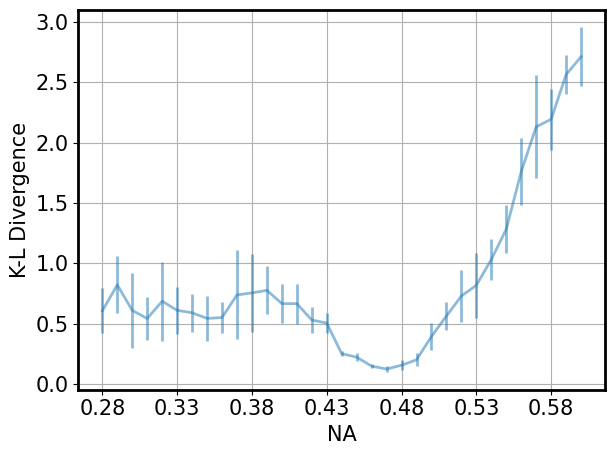

In [128]:
plt.errorbar(na, mean, std, linewidth=2, alpha=0.5, markersize=6)
plt.ylabel('K-L Divergence')
plt.xlabel('NA')
plt.grid()
plt.xticks(np.arange(0.28,0.61,0.05))
plt.savefig('kullback_leibler.pdf', dpi=300)
plt.show()

In [129]:
df = pd.DataFrame()
df['na'] = na
df['mean'] = mean
df['std'] = std
df.head()
df.to_csv('../data/results/kl.csv', index=None)